# Прогнозирование стоимости автомобиля.

Необходимо создать модель, которая будет предсказывать стоимость автомобиля по его характеристикам.

Оценка модели проводится по MAPE (Mean Absolute Percentage Error) по средней относительной ошибке прогноза.

По условию соревнования, нам нужно самостоятельно собрать обучающий датасет.

Поскольку спарсить данные с сайта avto.ru не получилось по объективным причинам (в первую очередь - недостаток опыта), модель будем строить на датасете из baseline.

In [1]:
import datetime

start = datetime.datetime.now()

## Библиотеки и функции

In [2]:
import numpy as np  
import pandas as pd  
import sys
import statistics
from itertools import combinations
from scipy.stats import ttest_ind
from datetime import datetime

import matplotlib.pyplot as plt  
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
from catboost import CatBoostRegressor
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, RobustScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from xgboost.sklearn import XGBRegressor
import xgboost as xgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import f_classif, mutual_info_classif

from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [3]:
#показывать dataframe без ограничения количества столбцов и 100 строк по умолчанию
pd.options.display.max_rows = 100
pd.options.display.max_columns = None

print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)

Python       : 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]
Numpy        : 1.20.3


In [4]:
# зафиксируем версии пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt
RANDOM_SEED = 42

In [5]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [6]:
# Функция, которая  ищет пересечение уникальных значений признаков.
def intersection_cols(col1,col2):   
    col1_set = set(col1.astype(str).unique())
    col2_set = set(col2.astype(str).unique())
    intersection = col1_set.intersection(col2_set)
    print(len(col1_set),len(col2_set),len(intersection))

In [7]:
# Функция выводит инфорамцию о границах выборосов для признака.
def iqr_test(series, mode=False):
    IQR = series.quantile(0.75) - series.quantile(0.25)
    perc25 = series.quantile(0.25)
    perc75 = series.quantile(0.75)

    low = perc25 - 1.5*IQR
    up = perc75 + 1.5*IQR

    if mode:
        return low, up

    print(
        "\n25-й перцентиль: {},".format(perc25),
        "\n75-й перцентиль: {},".format(perc75),
        "\nIQR: {}, ".format(IQR),
        "\nГраницы выбросов: [{low}, {up}].".format(
            low=perc25 - 1.5*IQR, up=perc75 + 1.5*IQR),
        "\n\nМинимальное значение признака: {}.".format(series.min()),
        "\nМаксимальное значение признака: {} .\n".format(series.max()))

    if series.min() < low:
        print("Найдены выбросы по нижней границе признака: Количество: {}, {}%".format(series.where(
            series < low).count(), round(series.where(series < low).count()/series.count()*100, 2)))
    if series.max() > up:
        print("Найдены выбросы по верхней границе признака: Количество: {}, {}%".format(series.where(
            series > up).count(), round(series.where(series > up).count()/series.count()*100, 2)))

In [8]:
# Функция для отрисовки коробочной диаграммы для нечисловых признаков.
def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(25, 5))
    plt.subplots_adjust(wspace=0.5)
    sns.boxplot(x=column, y='price',
                data=df[df['sample'] == 1],
                ax=ax)
    plt.xticks(rotation=45)

    ax.set_ylim(0, (df.price.quantile(0.75) + 8 *
                    (df.price.quantile(0.75) - df.price.quantile(0.25))))
    ax.set_title('Boxplot для ' + column + 'price')
    plt.show()

# Загрузка датасетов

In [9]:
VERSION = 16
# подключаем к ноутбуку внешний датасет
DIR_TRAIN = 'files/'
DIR_TEST = 'files/'
VAL_SIZE = 0.20   # 20%

In [10]:
train = pd.read_csv(DIR_TRAIN+'all_auto_ru_09_09_2020.csv')
test = pd.read_csv(DIR_TEST+'test.csv')
sample_submission = pd.read_csv(DIR_TEST+'sample_submission.csv')

In [11]:
train.sample(3)

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Комплектация,Привод,Руль,Состояние,Владельцы,ПТС,Таможня,Владение,price,start_date,hidden,model
66436,Седан T140,TOYOTA,FAFBFB,бензин,1982.0,1.5 AT (83 л.с.),4.0,1986,SEDAN AUTOMATIC 1.5,AUTOMATIC,1.5,83.0,Тойота корона дизель 2 С. Авто в удовлетворите...,100000,{'id': '0'},передний,RIGHT,NaN,3.0,ORIGINAL,True,NaN,150000.0,2020-08-30T18:17:26Z,NaN,CORONA
19979,Хэтчбек 5 дв.,FORD,040001,бензин,2005.0,1.6 AT (100 л.с.),5.0,2006,HATCHBACK_5_DOORS AUTOMATIC 1.6,AUTOMATIC,1.6,100.0,"Авто в достойном состоянии, за время эксплуата...",132500,"{'id': '20189955', 'name': 'Ghia', 'available_...",передний,LEFT,NaN,3.0,ORIGINAL,True,"{'year': 2019, 'month': 4}",280000.0,2020-08-10T10:16:54Z,NaN,FOCUS
89181,Внедорожник 5 дв.,SSANG_YONG,CACECB,бензин,2007.0,2.3 MT (150 л.с.) 4WD,5.0,2013,ALLROAD_5_DOORS MECHANICAL 2.3,MECHANICAL,2.3,150.0,Беспроблемная машина. В салоне не курили. Летн...,150000,{'id': '0'},полный,LEFT,NaN,2.0,ORIGINAL,True,NaN,690000.0,2020-02-01T17:14:11Z,NaN,KYRON


In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89378 entries, 0 to 89377
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              89377 non-null  object 
 1   brand                 89378 non-null  object 
 2   color                 89378 non-null  object 
 3   fuelType              89378 non-null  object 
 4   modelDate             89377 non-null  float64
 5   name                  89377 non-null  object 
 6   numberOfDoors         89377 non-null  float64
 7   productionDate        89378 non-null  int64  
 8   vehicleConfiguration  89377 non-null  object 
 9   vehicleTransmission   89377 non-null  object 
 10  engineDisplacement    89377 non-null  object 
 11  enginePower           89377 non-null  float64
 12  description           86124 non-null  object 
 13  mileage               89378 non-null  int64  
 14  Комплектация          89378 non-null  object 
 15  Привод             

In [13]:
test.head(3)

,bodyType,brand,car_url,color,complectation_dict,description,engineDisplacement,enginePower,equipment_dict,fuelType,image,mileage,modelDate,model_info,model_name,name,numberOfDoors,parsing_unixtime,priceCurrency,productionDate,sell_id,super_gen,vehicleConfiguration,vehicleTransmission,vendor,Владельцы,Владение,ПТС,Привод,Руль,Состояние,Таможня
0,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,синий,NaN,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,74000,2013,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.2 AMT (105 л.с.),5,1603226273,RUB,2014,1100575026,"{""id"":""10373605"",""displacement"":1197,""engine_t...",LIFTBACK ROBOT 1.2,роботизированная,EUROPEAN,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
1,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/octavia/1...,чёрный,NaN,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,https://autoru.naydex.net/o9DBXQ270/5ac010hAY0...,60563,2017,"{""code"":""OCTAVIA"",""name"":""Octavia"",""ru_name"":""...",OCTAVIA,1.6 MT (110 л.с.),5,1603226277,RUB,2017,1100549428,"{""id"":""20913311"",""displacement"":1598,""engine_t...",LIFTBACK MECHANICAL 1.6,механическая,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен
2,лифтбек,SKODA,https://auto.ru/cars/used/sale/skoda/superb/11...,серый,"{""id"":""20026336"",""name"":""Ambition"",""available_...","Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,https://avatars.mds.yandex.net/get-autoru-vos/...,88000,2013,"{""code"":""SUPERB"",""name"":""Superb"",""ru_name"":""Су...",SUPERB,DSG 1.8 AMT (152 л.с.),5,1603226280,RUB,2014,1100658222,"{""id"":""20026323"",""nameplate"":""DSG"",""displaceme...",LIFTBACK ROBOT 1.8,роботизированная,EUROPEAN,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен


In [14]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   bodyType              34686 non-null  object
 1   brand                 34686 non-null  object
 2   car_url               34686 non-null  object
 3   color                 34686 non-null  object
 4   complectation_dict    6418 non-null   object
 5   description           34686 non-null  object
 6   engineDisplacement    34686 non-null  object
 7   enginePower           34686 non-null  object
 8   equipment_dict        24690 non-null  object
 9   fuelType              34686 non-null  object
 10  image                 34686 non-null  object
 11  mileage               34686 non-null  int64 
 12  modelDate             34686 non-null  int64 
 13  model_info            34686 non-null  object
 14  model_name            34686 non-null  object
 15  name                  34686 non-null

In [15]:
test.columns

Index(['bodyType', 'brand', 'car_url', 'color', 'complectation_dict',
       'description', 'engineDisplacement', 'enginePower', 'equipment_dict',
       'fuelType', 'image', 'mileage', 'modelDate', 'model_info', 'model_name',
       'name', 'numberOfDoors', 'parsing_unixtime', 'priceCurrency',
       'productionDate', 'sell_id', 'super_gen', 'vehicleConfiguration',
       'vehicleTransmission', 'vendor', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня'],
      dtype='object')

- bodyType: Тип корпуса
- brand: Марка автомобиля
- car_url: Ссылка на страницу с продажей авто
- color: Цвет
- complectation_dict: Словарь, содержащий id, название комплектации, а также ее составляющие
- description: Дополнительное описание в свободной форме
- engineDisplacement: Объем двигателя
- enginePower: Мощность двигателя(значение + N12)
- equipment_dict: Комплетация автомобиля, отчасти пересекается с available_options в complectation_dict
- fuelType: Тип топлива
- image: Ссылка на изображения авто
- mileage: Пробег
- modelDate: год выпуска модели
- model_info: Информация о модели, марке автомобиля
- model_name: Модель авто
- name: Полное название в тренировочном, а в тестовом - информация о коробке передач, приводе, объеме двигателя, мощности итд
- numberOfDoors: Количество дверей
- parsing_unixtime: Дата и время, когда были спарсены данные; в формате unixtime
- price: искомый признак, цена продажи авто
- priceCurrency: Валюта, в которой продают автомоибль, везде рубли
- productionDate: Дата производства авто
- sell_id: id продажи автомобиля
- super_gen: В тестовом датасете по факту находятся данные не из super_gen, а из tech_param. Так что парсить для тренировочного датасета будем именно их. Часть данных здесь повторяется: объем двигателя, тип топлива, привод, коробка передач, мощность двигателя в л.с., мощность в киловаттах; а также новые полезные данные о: ускорение до 100 км/ч, клиренс, а также, по-видимому, расход топлива на 100 км
- vehicleConfiguration: Содержит информацию о типе корпуса, коробке передач и объеме двигателя
- vehicleTransmission: Коробка передач
- vendor: Регион производства
- Владельцы: Количество владельцев
- ПТС: Оригинал ПТС или нет
- Привод: Тип привода: передний, задний, полный
- Руль: Расположение руля
- Состояние: Требует или не требует ремонта
- Таможня: Растоможена ли машина
- Владение: Срок владения автомобилем

In [16]:
# Проверим соответствие колонок в train и test 
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:", dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:", dif_list)

Список колонок, которые есть только в test: ['image', 'model_info', 'sell_id', 'equipment_dict', 'parsing_unixtime', 'super_gen', 'car_url', 'complectation_dict', 'model_name', 'vendor', 'priceCurrency']
Список колонок, которые есть только в train: ['model', 'Комплектация', 'price', 'start_date', 'hidden']


В тестовом датасете 11 признаков, которых нет в тренировочном. 5 признаков есть только в тренировочном датасете, которых нет в тестовом. Однако, среди них price- это наш таргет, который требуется определить для теста, поэтому его оставляем.

В столбце hidden нет данных вообще, поэтому он под удаление. Столбец "Комплектация" в train соответствует столбцу complectation_dict в test, но поскольку оба столбца содержат много порпусков, удалим эти столбцы в test и в train. Столбец start_date от сутствует в test, поэтому он тоже под удаление.

In [17]:
train.drop(['hidden', 'start_date','Комплектация'], axis=1, inplace=True)
test.drop(['complectation_dict'], axis=1, inplace=True)

Столбцы train.model и test.model_name содержат одинаковую информацию о наименовании модели, поэтому просто переименуем этот столбец в тренировочном датасете.

In [18]:
train.rename(columns={'model': 'model_name'}, inplace=True)

In [19]:
# Еще раз проверим соответствие колонок в train и test 
dif_list = list(set(test.columns).difference(train.columns))
print("Список колонок, которые есть только в test:", dif_list)
dif_list = list(set(train.columns).difference(test.columns))
print("Список колонок, которые есть только в train:", dif_list)

Список колонок, которые есть только в test: ['parsing_unixtime', 'super_gen', 'image', 'car_url', 'model_info', 'sell_id', 'equipment_dict', 'vendor', 'priceCurrency']
Список колонок, которые есть только в train: ['price']


In [20]:
# Добавим столбец с ценой в тестовый датафрейм и заполним его нулями:
test['price'] = 0.0
# Добавим столбец с sell_id в тренировочный датафрейм изаполним его нулями:
train['sell_id'] = 0

## Удаление столбцов в test
Что касается остальных восьми признаков ('image', 'car_url', 'equipment_dict', 'vendor', 'priceCurrency', 'model_info', 'super_gen', 'parsing_unixtime'), то их будем удалять. Удаление priceCurrency и model_inf' не должно повлиять на данные, поскольку валюта продаж это рубли, а в столбе model_info продублирована марка авто.

In [21]:
test.priceCurrency.value_counts()

RUB    34686
Name: priceCurrency, dtype: int64

In [22]:
test.model_info[10]

'{"code":"RAPID","name":"Rapid","ru_name":"Рапид","morphology":{},"nameplate":{"code":"","name":"","semantic_url":""}}'

Переведя формат даты в столбце parsing_unixtime в обычный видим, что интервал дат сосредоточен с 19 по 26 октября 2020 года. И это нам вряд ли будет полезно.

In [23]:
test.parsing_unixtime = pd.to_datetime(test.parsing_unixtime, unit='s')
print(test.parsing_unixtime.min())
print(test.parsing_unixtime.max())

2020-10-19 11:35:06
2020-10-26 11:04:24


В equipment_dict имеются пропуски. Кроме того, из-за отсутствия парсинга нет возможности заполнить такие столбцы тренировочном сете, поэтому удаляем оставшиеся 8 в тестовом датасете:

In [24]:
test.drop(['image', 'car_url', 'equipment_dict', 'vendor', 'priceCurrency', 'model_info',
           'super_gen', 'parsing_unixtime'], axis=1, inplace=True)

In [25]:
test['Состояние'].value_counts()

Не требует ремонта    34686
Name: Состояние, dtype: int64

In [26]:
test.drop(['Состояние', 'Владение'], axis=1, inplace=True)
train.drop(['Состояние', 'Владение'], axis=1, inplace=True)

## EDA

Перед объединением датасетов проверим типы данных в train и test. Сгенерируем список с колонками, которые есть и в train, и в test:

In [27]:
cols_cross = list(set(test.columns).intersection(train.columns))
cols_diff_type = []  # создаем список с колонками, в которых типы данных отличаются
#print("Расхождения в типах данных для:")

for col in cols_cross:
    if type(test[col][0]) != type(train[col][0]):
        print(
            f"\t столбец {col}: для train - {type(train[col][0])}, для test - {type(test[col][0])}")
        cols_diff_type.append(col)

	 столбец numberOfDoors: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	 столбец Таможня: для train - <class 'numpy.bool_'>, для test - <class 'str'>
	 столбец modelDate: для train - <class 'numpy.float64'>, для test - <class 'numpy.int64'>
	 столбец enginePower: для train - <class 'numpy.float64'>, для test - <class 'str'>
	 столбец Владельцы: для train - <class 'numpy.float64'>, для test - <class 'str'>


In [28]:
# Приводим данные в колонках к одному типу, там, где это возможно

train.numberOfDoors = train.numberOfDoors.astype('Int64')
train.modelDate = train.modelDate.astype('Int64')

Разберем отдельно оставшиеся признаки с разными типами данных:

In [29]:
test['Таможня'].value_counts()

Растаможен    34686
Name: Таможня, dtype: int64

In [30]:
train['Таможня'].value_counts()

True    89378
Name: Таможня, dtype: int64

In [31]:
#все машины расстаможены - удаляем
test.drop(['Таможня'], axis=1, inplace=True)
train.drop(['Таможня'], axis=1, inplace=True)

In [32]:
#Мощность двигателя

test.enginePower.value_counts()

249 N12    1708
150 N12    1699
110 N12    1039
170 N12     977
105 N12     955
           ... 
514 N12       1
626 N12       1
38 N12        1
32 N12        1
301 N12       1
Name: enginePower, Length: 315, dtype: int64

In [33]:
#Сократим обучающую выбрку только до брендов, которые есть в тестовой выборке.

brand_test=test.brand.unique()
brand_train=train.brand.unique()

print(brand_test)
print(brand_train)

['SKODA' 'AUDI' 'HONDA' 'VOLVO' 'BMW' 'NISSAN' 'INFINITI' 'MERCEDES'
 'TOYOTA' 'LEXUS' 'VOLKSWAGEN' 'MITSUBISHI']
['AUDI' 'BMW' 'CADILLAC' 'CHERY' 'CHEVROLET' 'CHRYSLER' 'CITROEN' 'DAEWOO'
 'DODGE' 'FORD' 'GEELY' 'HONDA' 'HYUNDAI' 'INFINITI' 'JAGUAR' 'JEEP' 'KIA'
 'LEXUS' 'MAZDA' 'MINI' 'MITSUBISHI' 'NISSAN' 'OPEL' 'PEUGEOT' 'PORSCHE'
 'RENAULT' 'SKODA' 'SUBARU' 'SUZUKI' 'TOYOTA' 'VOLKSWAGEN' 'VOLVO'
 'GREAT_WALL' 'LAND_ROVER' 'MERCEDES' 'SSANG_YONG']


In [34]:
#видим, что в трейне спектр марок куда шире. уберем лишнее

train=train[train['brand'].isin (brand_test)]
train=train[train['price']>0]

print(train.brand.unique())

['AUDI' 'BMW' 'HONDA' 'INFINITI' 'LEXUS' 'MITSUBISHI' 'NISSAN' 'SKODA'
 'TOYOTA' 'VOLKSWAGEN' 'VOLVO' 'MERCEDES']


In [35]:
#проделаем то же для моделей
model_test=test.model_name.unique()
print('Количество моделей в исходном трейне', len(train.model_name.unique()))
train=train[train['model_name'].isin (model_test)]

print('Количество моделей в модифицированном трейне', len(train.model_name.unique()))
print('Количество моделей в тестовом датасете',len(model_test))

Количество моделей в исходном трейне 554
Количество моделей в модифицированном трейне 525
Количество моделей в тестовом датасете 544


In [36]:
#Посмотрим на пересечение значений столбца name в тесте и трейне:

intersection_cols(test.name,train.name)

2780 2881 2469


Как видно, из 2780 уникальных значений тестового датасета, ~89% встречаются в трейне.

In [37]:
#Удалим из трейна отсутствующие в тесте позиции

#name_test=test.name.unique()
#print('Количество значений name в исходном трейне', len(train.name.unique()))
#train=train[train['name'].isin (name_test)]
#print('Количество значений name в модифицированном трейне', len(train.name.unique()))

#вопреки ожиданиям, эта операция в отличие от двух предыдущих ухудшила оценку.

In [38]:
test.enginePower.unique()

array(['105 N12', '110 N12', '152 N12', '200 N12', '102 N12', '150 N12',
       '90 N12', '180 N12', '220 N12', '122 N12', '70 N12', '140 N12',
       '125 N12', '54 N12', '86 N12', '75 N12', '64 N12', '95 N12',
       '260 N12', '170 N12', '80 N12', '68 N12', '160 N12', '115 N12',
       '280 N12', '53 N12', '60 N12', '143 N12', '42 N12', '101 N12',
       '58 N12', '193 N12', '79 N12', '30 N12', '100 N12', '50 N12',
       '163 N12', '225 N12', '420 N12', '211 N12', '245 N12', '560 N12',
       '500 N12', '249 N12', '450 N12', '605 N12', '250 N12', '354 N12',
       '120 N12', '290 N12', '230 N12', '350 N12', '204 N12', '255 N12',
       '340 N12', '177 N12', '272 N12', '372 N12', '210 N12', '130 N12',
       '300 N12', '190 N12', '239 N12', '435 N12', '333 N12', '271 N12',
       '326 N12', '238 N12', '310 N12', '233 N12', '252 N12', '133 N12',
       '460 N12', '520 N12', '400 N12', '525 N12', '367 N12', '265 N12',
       '550 N12', '580 N12', '88 N12', '165 N12', '430 N12', '335 N

In [39]:
train.enginePower.value_counts()

249.0    3377
150.0    3136
110.0    1872
190.0    1802
184.0    1439
         ... 
402.0       1
108.0       1
550.0       1
61.0        1
30.0        1
Name: enginePower, Length: 314, dtype: int64

In [40]:
train.enginePower.unique()

array([174.,  90., 136., 101., 133., 150., 115., 137., 112., 230.,  70.,
        88., 100.,  75., 165., 182., 170., 113.,  80.,  54.,  60.,  71.,
       122., 125.,  61., 102., 190., 180., 160., 105., 140., 110., 250.,
       200., 130., 120., 225., 163., 211., 249., 255., 143., 220., 239.,
       265., 116., 193., 177., 240., 245., 204., 340., 300., 233., 310.,
       210., 218., 290., 333., 335., 224., 350., 155., 254., 338., 435.,
       372., 460., 275., 500., 260., 450., 420., 280., 326., 285., 408.,
       271., 272., 270., 238., 252., 610., 525., 430., 367., 605., 560.,
       580., 256., 354., 571., 360., 520., 400., 156., 306., 320., 184.,
       129., 258., 231., 118., 286., 192.,  98., 234., 171.,  46.,  51.,
       407., 530., 235., 381., 462., 197., 109., 313., 609., 544., 445.,
       329., 188., 370., 410., 431., 343., 507., 600., 625., 510., 355.,
       269., 264., 347., 555., 575., 321., 201., 281., 131., 154., 152.,
       147., 135.,  53., 215.,  44., 142.,  95.,  9

In [41]:
# Данные test и train лучше перевести  целые числа:

train.enginePower = train.enginePower.astype('Int64')

# функция для перевода test.enginePower  в целые числа:
def enginePower_int(x):
    x = str(x).split(' ')[0]
    if x == 'nan' or x == 'undefined':
        return np.nan
    return int(x)

test.enginePower = test.enginePower.apply(enginePower_int)

In [42]:
train.enginePower

0        174
1         90
2        136
3         90
4        101
        ... 
88655    150
88656    150
88658    258
88659    190
88660    258
Name: enginePower, Length: 49033, dtype: Int64

In [43]:
test.enginePower

0        105
1        110
2        152
3        110
4        152
        ... 
34681    136
34682    190
34683    170
34684    184
34685    235
Name: enginePower, Length: 34686, dtype: int64

In [44]:
#Количество воладельцев

test['Владельцы'].unique()

array(['3 или более', '1\xa0владелец', '2\xa0владельца'], dtype=object)

In [45]:
train['Владельцы'].unique()

array([ 3.,  1.,  2., nan])

In [46]:
# Преобразуем значения в test в числовые (float) для этого создадим словарь:
dict_owners = {'3 или более': 3., '2\xa0владельца': 2., '1\xa0владелец': 1.}

test['Владельцы'].replace(dict_owners, inplace=True)

In [47]:
test['Владельцы'].value_counts()

3.0    15957
1.0     9459
2.0     9270
Name: Владельцы, dtype: int64

In [48]:
#Цвет автомобиля
train['color'].value_counts()

040001    16120
FAFBFB     8972
97948F     5613
CACECB     5492
0000CC     4958
200204     2028
EE1D19     1781
007F00     1315
C49648      857
22A0F8      591
DEA522      316
660099      314
4A2197      247
FFD600      223
FF8649      193
FFC0CB       13
Name: color, dtype: int64

In [49]:
test['color'].value_counts()

чёрный         11010
белый           6133
серебристый     4113
серый           3984
синий           3289
красный         1531
коричневый      1501
зелёный          952
бежевый          639
голубой          457
золотистый       266
пурпурный        254
фиолетовый       219
жёлтый           194
оранжевый        131
розовый           13
Name: color, dtype: int64

Признак цвет(color) в test и train записан по разному. Аналогично предыдущему пункту создадим словарь и применим его к тренировочному сету, чтобы цвета были легко читаемы и потом будем объединять датасеты.

In [50]:
dict_color = {'040001': 'чёрный', 'FAFBFB': 'белый', 'CACECB': 'серебристый', '97948F': 'серый', '0000CC': 'синий','EE1D19': 'красный', '200204': 'коричневый',
                '007F00': 'зелёный', 'C49648': 'бежевый', '22A0F8': 'голубой', '660099': 'пурпурный', 'DEA522': 'золотистый',
              '4A2197': 'фиолетовый', 'FFD600': 'жёлтый', 'FF8649': 'оранжевый', 'FFC0CB': 'розовый'}
train.replace(dict_color, inplace=True)
train.color.value_counts()

чёрный         16120
белый           8972
серый           5613
серебристый     5492
синий           4958
коричневый      2028
красный         1781
зелёный         1315
бежевый          857
голубой          591
золотистый       316
пурпурный        314
фиолетовый       247
жёлтый           223
оранжевый        193
розовый           13
Name: color, dtype: int64

In [51]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34686 entries, 0 to 34685
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              34686 non-null  object 
 1   brand                 34686 non-null  object 
 2   color                 34686 non-null  object 
 3   description           34686 non-null  object 
 4   engineDisplacement    34686 non-null  object 
 5   enginePower           34686 non-null  int64  
 6   fuelType              34686 non-null  object 
 7   mileage               34686 non-null  int64  
 8   modelDate             34686 non-null  int64  
 9   model_name            34686 non-null  object 
 10  name                  34686 non-null  object 
 11  numberOfDoors         34686 non-null  int64  
 12  productionDate        34686 non-null  int64  
 13  sell_id               34686 non-null  int64  
 14  vehicleConfiguration  34686 non-null  object 
 15  vehicleTransmission

In [52]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49033 entries, 0 to 88660
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              49032 non-null  object 
 1   brand                 49033 non-null  object 
 2   color                 49033 non-null  object 
 3   fuelType              49033 non-null  object 
 4   modelDate             49032 non-null  Int64  
 5   name                  49032 non-null  object 
 6   numberOfDoors         49032 non-null  Int64  
 7   productionDate        49033 non-null  int64  
 8   vehicleConfiguration  49032 non-null  object 
 9   vehicleTransmission   49032 non-null  object 
 10  engineDisplacement    49032 non-null  object 
 11  enginePower           49032 non-null  Int64  
 12  description           47456 non-null  object 
 13  mileage               49033 non-null  int64  
 14  Привод                49032 non-null  object 
 15  Руль               

### Объединим train и test

In [53]:
# при объединении дата сетов добавляем столбец sample для возможности разделения сетов на первоначальные  наборы данных:

train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83719 entries, 0 to 83718
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              83718 non-null  object 
 1   brand                 83719 non-null  object 
 2   color                 83719 non-null  object 
 3   fuelType              83719 non-null  object 
 4   modelDate             83718 non-null  Int64  
 5   name                  83718 non-null  object 
 6   numberOfDoors         83718 non-null  Int64  
 7   productionDate        83719 non-null  int64  
 8   vehicleConfiguration  83718 non-null  object 
 9   vehicleTransmission   83718 non-null  object 
 10  engineDisplacement    83718 non-null  object 
 11  enginePower           83718 non-null  Int64  
 12  description           82142 non-null  object 
 13  mileage               83719 non-null  int64  
 14  Привод                83718 non-null  object 
 15  Руль               

Расмотрим остальные признаки, перед тем как заполнять/удалять пропуски.

In [54]:
#Тип кузова
df.bodyType.unique()

array(['Седан', 'Универсал 5 дв.', 'Хэтчбек 5 дв. Sportback',
       'Хэтчбек 3 дв.', 'Хэтчбек 5 дв.', 'Кабриолет', 'Купе',
       'Лифтбек Sportback', 'Лифтбек', 'Седан Long', 'Внедорожник 5 дв.',
       'Кабриолет Roadster', 'Седан 2 дв.', 'Седан Gran Coupe',
       'Компактвэн', 'Компактвэн Gran Tourer', 'Лифтбек Gran Turismo',
       'Хэтчбек 3 дв. Compact', 'Лифтбек Gran Coupe', 'Купе-хардтоп',
       'Родстер Roadster', 'Родстер', 'Седан Type-S', 'Микровэн',
       'Универсал 5 дв. Shuttle', nan, 'Родстер del Sol', 'Минивэн',
       'Компактвэн Spike', 'Внедорожник 3 дв.', 'Пикап Двойная кабина',
       'Минивэн Spada', 'Внедорожник 5 дв. L', 'Универсал 5 дв. Plus',
       'Купе Asti', 'Тарга', 'Фастбек', 'Пикап Одинарная кабина',
       'Минивэн Caravan Elgrand', 'Пикап Полуторная кабина',
       'Компактвэн Joy', 'Универсал 5 дв. California', 'Седан Latio',
       'Седан 120', 'Хэтчбек 5 дв. Scout', 'Универсал 5 дв. Scout',
       'Универсал 5 дв. Spaceback', 'Универсал 5 дв. G

Признак содержит не только информацию о типе кузова, но и количество дверей и даже марка авто. Унифицируем его, оставив только тип кузова.

In [55]:
df.bodyType = df.bodyType.apply(lambda x: x.lower().split()[
                                0].strip() if isinstance(x, str) else x)

In [56]:
df.bodyType.unique()

array(['седан', 'универсал', 'хэтчбек', 'кабриолет', 'купе', 'лифтбек',
       'внедорожник', 'компактвэн', 'купе-хардтоп', 'родстер', 'микровэн',
       nan, 'минивэн', 'пикап', 'тарга', 'фастбек', 'седан-хардтоп',
       'фургон', 'лимузин'], dtype=object)

In [57]:
#Марка
print(df.brand.unique())

['AUDI' 'BMW' 'HONDA' 'INFINITI' 'LEXUS' 'MITSUBISHI' 'NISSAN' 'SKODA'
 'TOYOTA' 'VOLKSWAGEN' 'VOLVO' 'MERCEDES']


In [58]:
df.brand.value_counts()

MERCEDES      12151
BMW           11834
VOLKSWAGEN    11513
NISSAN        10135
TOYOTA         8701
AUDI           7459
MITSUBISHI     6761
SKODA          5536
VOLVO          3525
HONDA          2318
INFINITI       1907
LEXUS          1879
Name: brand, dtype: int64

In [59]:
#тип двигателя
df.fuelType.unique()

array(['бензин', 'дизель', 'электро', 'гибрид', 'универсал', 'газ'],
      dtype=object)

In [60]:
df.fuelType.value_counts()

бензин       67800
дизель       15261
гибрид         491
электро        149
газ             17
универсал        1
Name: fuelType, dtype: int64

In [61]:
#год начала выпуска модели
df.modelDate.unique()

<IntegerArray>
[1990, 1982, 1988, 1976, 1983, 1979, 1986, 1991, 1978, 1987, 1992, 1938, 2010,
 2014, 2000, 2016, 2004, 2012, 2008, 1996, 2003, 2015, 2011, 2007, 1999, 1994,
 2009, 2018, 2001, 1997, 2006, 2019, 2013, 2017, 2002, 2005, 1980, 1984, 1998,
 1966, 1975, 1937, 1936, 1949, 2020, 1995, 1981, 1972, 1977, 1989, 1968, 1993,
 1985, <NA>, 1973, 1969, 1934, 1960, 1974, 1955, 1965, 1904, 1963, 1971, 1959,
 1958, 1951]
Length: 67, dtype: Int64

In [62]:
# количество дверей
df.numberOfDoors.unique()

<IntegerArray>
[4, 5, 3, 2, <NA>, 0]
Length: 6, dtype: Int64

In [63]:
df.numberOfDoors.value_counts()

5    46288
4    33411
2     2631
3     1386
0        2
Name: numberOfDoors, dtype: Int64

Проверим строки(их всего две) с нулевым количеством дверей. Как видно ниже, у нас явно имеется дублирование объявлений, но удалять не будем (они относятся к разным частям объединенного датасета):

In [64]:
df.loc[df.numberOfDoors==0]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleConfiguration,vehicleTransmission,engineDisplacement,enginePower,description,mileage,Привод,Руль,Владельцы,ПТС,price,model_name,sell_id,sample
48447,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,MECHANICAL,5.3,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,задний,RIGHT,1.0,ORIGINAL,12000000.0,SIMPLEX,0,1
65977,кабриолет,MERCEDES,белый,бензин,1904,5.3 MT (32 л.с.),0,1904,CABRIO MECHANICAL 5.3,механическая,5.3 LTR,32,"на ходу. 1904 год. стоит в гараже, пылится.Кат...",48000,задний,Правый,1.0,Оригинал,0.0,SIMPLEX,1093802104,0


In [65]:
#год выпуска автомобиля.
df.productionDate.unique()

array([1991, 1986, 1989, 1993, 1992, 1994, 1987, 1988, 1985, 1983, 1980,
       1984, 1990, 1981, 1995, 1938, 2014, 2011, 2013, 2012, 2016, 2010,
       2002, 2000, 2001, 2020, 2008, 2018, 2015, 2019, 2007, 2003, 2017,
       2006, 2005, 2004, 2009, 1997, 1999, 1998, 1996, 1982, 1972, 1978,
       1937, 1949, 1948, 1950, 1953, 1975, 1969, 1979, 1976, 1939, 1974,
       1973, 1954, 1970, 1961, 1960, 1957, 1968, 1977, 1904, 1967, 1966,
       1965, 1963, 1959, 1936, 1952], dtype=int64)

Пока оставляем как есть, но есть предположение, что этот признак сильно коррелирует с modelDate. Возможно один из них предется удалить.

In [66]:
#тип кузова, кпп и т.п.
df.vehicleConfiguration.unique()

array(['SEDAN MECHANICAL 2.8', 'SEDAN MECHANICAL 1.8',
       'WAGON_5_DOORS MECHANICAL 2.3', ..., 'MINIVAN VARIATOR 1.5',
       'COMPACTVAN VARIATOR 1.3', 'ALLROAD_OPEN AUTOMATIC 2.0'],
      dtype=object)

In [67]:
df.vehicleConfiguration.value_counts()

ALLROAD_5_DOORS VARIATOR 2.0     4232
SEDAN MECHANICAL 1.6             2937
ALLROAD_5_DOORS AUTOMATIC 3.0    2677
ALLROAD_5_DOORS AUTOMATIC 2.0    2323
SEDAN AUTOMATIC 2.0              2274
                                 ... 
ROADSTER AUTOMATIC 380              1
ROADSTER AUTOMATIC 300              1
MINIVAN AUTOMATIC 2.3d              1
SEDAN MECHANICAL VR-4               1
ALLROAD_OPEN AUTOMATIC 2.0          1
Name: vehicleConfiguration, Length: 1565, dtype: int64

Данный признак содержит слишком много информации. Посмотрим , есть ли дублирование по другим признакам и , возможно, его тоже будем удалять. Тип кузова и количество дверей у нас уже есть, а также столбец с транссмиссией. Если мы оставим признак name, то в vehicleConfiguration не будет необходимости.

In [68]:
#тип КПП
df.vehicleTransmission.value_counts()

AUTOMATIC           28277
автоматическая      19596
MECHANICAL           8792
механическая         7209
VARIATOR             6243
ROBOT                5720
вариатор             3999
роботизированная     3882
Name: vehicleTransmission, dtype: int64

In [69]:
df.vehicleTransmission.unique()

array(['MECHANICAL', 'AUTOMATIC', 'ROBOT', 'VARIATOR', nan,
       'роботизированная', 'механическая', 'автоматическая', 'вариатор'],
      dtype=object)

In [70]:
#унифицируем типы
dict_transm = {'автоматическая': 'AUTOMATIC', 'механическая': 'MECHANICAL', 'вариатор': 'VARIATOR', 'роботизированная' : 'ROBOT'}

df.vehicleTransmission.replace(dict_transm, inplace=True)

In [71]:
#объем двигателя
df.engineDisplacement.value_counts().head(100)

2.0 LTR    7391
2.0        7028
1.6        5725
1.6 LTR    4973
3.0 LTR    3915
1.8 LTR    3349
1.8        3037
2.5 LTR    2477
1.4        2337
2.5        1806
2.4 LTR    1745
3.5 LTR    1710
1.4 LTR    1635
2.4        1559
200        1514
350        1494
2.0d        995
3.5         967
3.0d        913
1.5 LTR     725
300         688
3.0         683
2.5d        619
250         591
500         574
1.5         569
320i        550
450         501
20d         496
30d         494
1.2 LTR     485
180         482
1.2         477
400         473
2.4d        468
4.4 LTR     447
2.8 LTR     384
4.7 LTR     377
1.3 LTR     365
5.5 LTR     361
4.0 LTR     356
3.2 LTR     348
4.5 LTR     346
520d        344
20i         327
63          326
520i        322
4.5d        318
320         309
220         302
320d        287
1.3         278
2.1 LTR     271
35i         256
3.7 LTR     242
2.2 LTR     236
2.8         233
530d        228
4.2 LTR     228
1.9d        226
1.9 LTR     221
4.0         218
3.6     

In [72]:
df.engineDisplacement.unique()

array(['2.8', '1.8', '2.3', '2.0', '2.6', '2.2', 'S4', '2.0d', '2.5d',
       '1.9', '2.1', '2.4', '1.6', '1.9d', '1.6d', '1.3', '3.3', '1.4',
       '1.2d', 'ultra', '1.2', '3.2', '1.5', '8V', '3.1', '3.0d', '2.7d',
       '16V', '3.0', '7S-tronic', 'tiptronic', '40', '45', '55', '2.7',
       '4.2', 'S-tronic', 'Tiptronic', 'Long', '4.0', '60', '3.9d', '6.0',
       '3.7', '4.1d', '35', '8tiptronic', 'clean', '2.0hyb', '3.6',
       '5.9d', 'V10', 'V8', '2.5', '2.9', '5.0', '5.2', 'M135i', '116i',
       '120i', '118i', '135i', 'M140i', '125i', '120d', '130i', '118d',
       '218i', '220i', '220d', 'M235i', '218d', '216d', '335i', '320i',
       '318i', '318d', '320d', '316i', '328i', '330i', '325xi', '325i',
       '330d', '340i', '323i', '335d', '335xi', '330xi', '316', '315',
       '318', 'N46', '420d', '428i', '420i', '435i', '430i', '440i',
       '520d', '530d', '525i', '523i', '520i', '530i', '525d', '528i',
       '550i', '535d', 'M550i', 'M550d', '540i', '535i', '530xi', '5

In [73]:
#Посмотрим на пересечение значений этого столбца в тесте и трейне:
intersection_cols(test.engineDisplacement,train.engineDisplacement)

55 412 0


Пересечения в тесте и трейне отсутствуют. Поэтому придется удалить признак.

In [74]:
#описание предложения
df.description[25]

'На ходу двигаюсь каждый день Все интересующие вопросы по телефону'

In [75]:
df.description.isna().sum()

1577

Много текста и много пропусков. что делать с этим массивом не понятно, ибо, как говорится, каждый кулик своё болото хвалит, и формальная оценка тональности (textblob итд) едва ли даст сколько-то значимый результат. так что придется удалить, как ни жаль. 

In [76]:
#пробег
df.mileage.value_counts()

0         10917
200000     1000
150000      877
300000      834
250000      829
          ...  
101505        1
24959         1
243945        1
172800        1
157965        1
Name: mileage, Length: 17165, dtype: int64

In [77]:
df['Привод'].unique()

array(['полный', 'передний', 'задний', nan], dtype=object)

In [78]:
df['Привод'].value_counts()

полный      38566
передний    35144
задний      10008
Name: Привод, dtype: int64

In [79]:
df['Руль'].unique()

array(['LEFT', 'RIGHT', 'Левый', 'Правый'], dtype=object)

In [80]:
df['Руль'] = df['Руль'].apply(lambda x: 'Левый' if x=='LEFT' else 'Правый')

In [81]:
df['Руль'].value_counts()

Левый     47516
Правый    36203
Name: Руль, dtype: int64

In [82]:
df['ПТС'].unique()

array(['ORIGINAL', 'DUPLICATE', nan, 'Оригинал', 'Дубликат'], dtype=object)

In [83]:
df['ПТС'].isna().sum()

262

In [84]:
df['ПТС'] = df['ПТС'].apply(lambda x: 'Дубликат' if x=='DUPLICATE' else x)
df['ПТС'] = df['ПТС'].apply(lambda x: 'Оригинал' if x=='ORIGINAL' else x)

'ПТС' и 'Руль' - бинарные признаки

In [85]:
#название модели
df.model_name.value_counts()

OCTAVIA       2910
5ER           2695
E_KLASSE      2235
PASSAT        2176
3ER           2166
              ... 
PRESEA           1
OTTI             1
300ZX            1
TORNEO           1
WILL_CYPHA       1
Name: model_name, Length: 544, dtype: int64

In [86]:
# признаки, отобранные для удаления, убираем из датасета:
df.drop(['vehicleConfiguration', 'engineDisplacement'], axis=1, inplace=True)
df.drop(['description'], axis=1, inplace=True)

In [87]:
# для удобства работы все рускоязычные наименования признаков заменим английскими:
df.rename(columns={'Владельцы': 'owners', 'Привод': 'driveUnit',
          'Руль': 'steeringWheel', 'ПТС': 'vehiclePassport'}, inplace=True)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83719 entries, 0 to 83718
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             83718 non-null  object 
 1   brand                83719 non-null  object 
 2   color                83719 non-null  object 
 3   fuelType             83719 non-null  object 
 4   modelDate            83718 non-null  Int64  
 5   name                 83718 non-null  object 
 6   numberOfDoors        83718 non-null  Int64  
 7   productionDate       83719 non-null  int64  
 8   vehicleTransmission  83718 non-null  object 
 9   enginePower          83718 non-null  Int64  
 10  mileage              83719 non-null  int64  
 11  driveUnit            83718 non-null  object 
 12  steeringWheel        83719 non-null  object 
 13  owners               72802 non-null  float64
 14  vehiclePassport      83457 non-null  object 
 15  price                83719 non-null 

Таким образом, полученный датасет имеет 19 признаков, из которых:

2 признака служебные (sell_id и sample)

1 признак - целевая переменная (price)

16 признаков, к которым относятся: 2 бинарных (vehiclePassport и steeringWheel) 6 числовых (modelDate, numberOfDoors, productionDate, enginePower, mileage, Owners) 8 категориальных(bodyType, brand, color,fuelType, vehicleTransmission, Drive_unit, model_name, name)

## Работа с пропусками

Практически все признаки не имеют пропусков, но в 6 признаках по 1 пропуску. Попробуем найти эту строку и удалим ее

In [89]:
df.loc[df.modelDate.isna() | df.bodyType.isna()]

,bodyType,brand,color,fuelType,modelDate,name,numberOfDoors,productionDate,vehicleTransmission,enginePower,mileage,driveUnit,steeringWheel,owners,vehiclePassport,price,model_name,sell_id,sample
12002,NaN,HONDA,серебристый,универсал,<NA>,NaN,<NA>,1989,NaN,<NA>,400000,NaN,Левый,3.0,Оригинал,120000.0,CIVIC,0,1


In [90]:
# удаляем строку с максимальным количеством пропусков:
df.drop(index=[12002], inplace=True)

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83718 entries, 0 to 83718
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             83718 non-null  object 
 1   brand                83718 non-null  object 
 2   color                83718 non-null  object 
 3   fuelType             83718 non-null  object 
 4   modelDate            83718 non-null  Int64  
 5   name                 83718 non-null  object 
 6   numberOfDoors        83718 non-null  Int64  
 7   productionDate       83718 non-null  int64  
 8   vehicleTransmission  83718 non-null  object 
 9   enginePower          83718 non-null  Int64  
 10  mileage              83718 non-null  int64  
 11  driveUnit            83718 non-null  object 
 12  steeringWheel        83718 non-null  object 
 13  owners               72801 non-null  float64
 14  vehiclePassport      83456 non-null  object 
 15  price                83718 non-null 

In [92]:
print (df.owners.isna().sum())
print (df.vehiclePassport.isna().sum())
print(df.price.isna().sum())

10917
262
0


In [93]:
# остались пропуски в признаках Владельцы и ПТС.
#заполним пропуски по собственникам модой в соответствии с model_name или productionDate

#df.owners = df.groupby("productionDate")["owners"].\
#    transform(lambda x: x.fillna(x.mode()[0]))

#cтранно, но идея с таким, казалось бы, логичным обоснованием работает хуже, чем просто заполнить модой.
df.owners.fillna((df.owners.mode()[0]), inplace=True)

df.vehiclePassport.fillna((df.vehiclePassport.mode()[0]), inplace=True)
#вообще мест под запись в птс шесть. но первую зачастую занимает автосалон, могут быть передачи между супругами итп. 
#плюс птс можно потерять, его могут украсть... в общем с этим признаком ничего лучше моды не придумать. да и пропусков немного.

In [94]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83718 entries, 0 to 83718
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             83718 non-null  object 
 1   brand                83718 non-null  object 
 2   color                83718 non-null  object 
 3   fuelType             83718 non-null  object 
 4   modelDate            83718 non-null  Int64  
 5   name                 83718 non-null  object 
 6   numberOfDoors        83718 non-null  Int64  
 7   productionDate       83718 non-null  int64  
 8   vehicleTransmission  83718 non-null  object 
 9   enginePower          83718 non-null  Int64  
 10  mileage              83718 non-null  int64  
 11  driveUnit            83718 non-null  object 
 12  steeringWheel        83718 non-null  object 
 13  owners               83718 non-null  float64
 14  vehiclePassport      83718 non-null  object 
 15  price                83718 non-null 

## Визуализация данных

In [95]:
# посмотрим на количество уникальных значений в каждом признаке:
df.nunique(dropna=False)

bodyType                  18
brand                     12
color                     16
fuelType                   5
modelDate                 66
name                    3191
numberOfDoors              5
productionDate            71
vehicleTransmission        4
enginePower              323
mileage                17165
driveUnit                  3
steeringWheel              2
owners                     3
vehiclePassport            2
price                   6451
model_name               544
sell_id                34687
sample                     2
dtype: int64

Распределим признаки по категориям, признаки model_name и name содержат слишком много значений, которые трудно объединить по подкатегориям, поэтому их включим в отдельную категорию:

In [96]:
# бинарные признаки
bin_cols = ['vehiclePassport', 'steeringWheel']

# категориальные переменные
cat_cols = ['bodyType', 'brand', 'color', 'fuelType',
            'vehicleTransmission', 'driveUnit']

# категориальные переменные с большим количеством категорий:
cat_cols_many = ['name', 'model_name']

# числовые переменные
num_cols = ['modelDate', 'productionDate', 'numberOfDoors',
            'enginePower', 'mileage', 'owners']

# служебные переменные
service_cols = ['sample', 'sell_id']

# целевая переменная
target_col = ['price']

cols_all = bin_cols + cat_cols + cat_cols_many + \
    num_cols + service_cols + target_col

In [97]:
# проверим, все ли признаки учтены:
len(cols_all)

19

### ЧИСЛОВЫЕ ПРИЗНАКИ

In [98]:
print("Основные параметры статистики для числовых признаков")
display(df[num_cols].describe())

Основные параметры статистики для числовых признаков


,modelDate,productionDate,numberOfDoors,enginePower,mileage,owners
count,83718.000000,83718.000000,83718.000000,83718.000000,83718.000000,83718.000000
mean,2008.166798,2010.376227,4.473399,190.529850,143978.287883,2.328854
std,7.878003,7.568755,0.686621,88.638307,109709.323605,0.811934
min,1904.000000,1904.000000,0.000000,30.000000,0.000000,1.000000
25%,2004.000000,2007.000000,4.000000,135.000000,61000.000000,2.000000
50%,2009.000000,2011.000000,5.000000,170.000000,136000.000000,3.000000
75%,2014.000000,2016.000000,5.000000,235.000000,205000.000000,3.000000
max,2020.000000,2020.000000,5.000000,800.000000,1000000.000000,3.000000


Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной


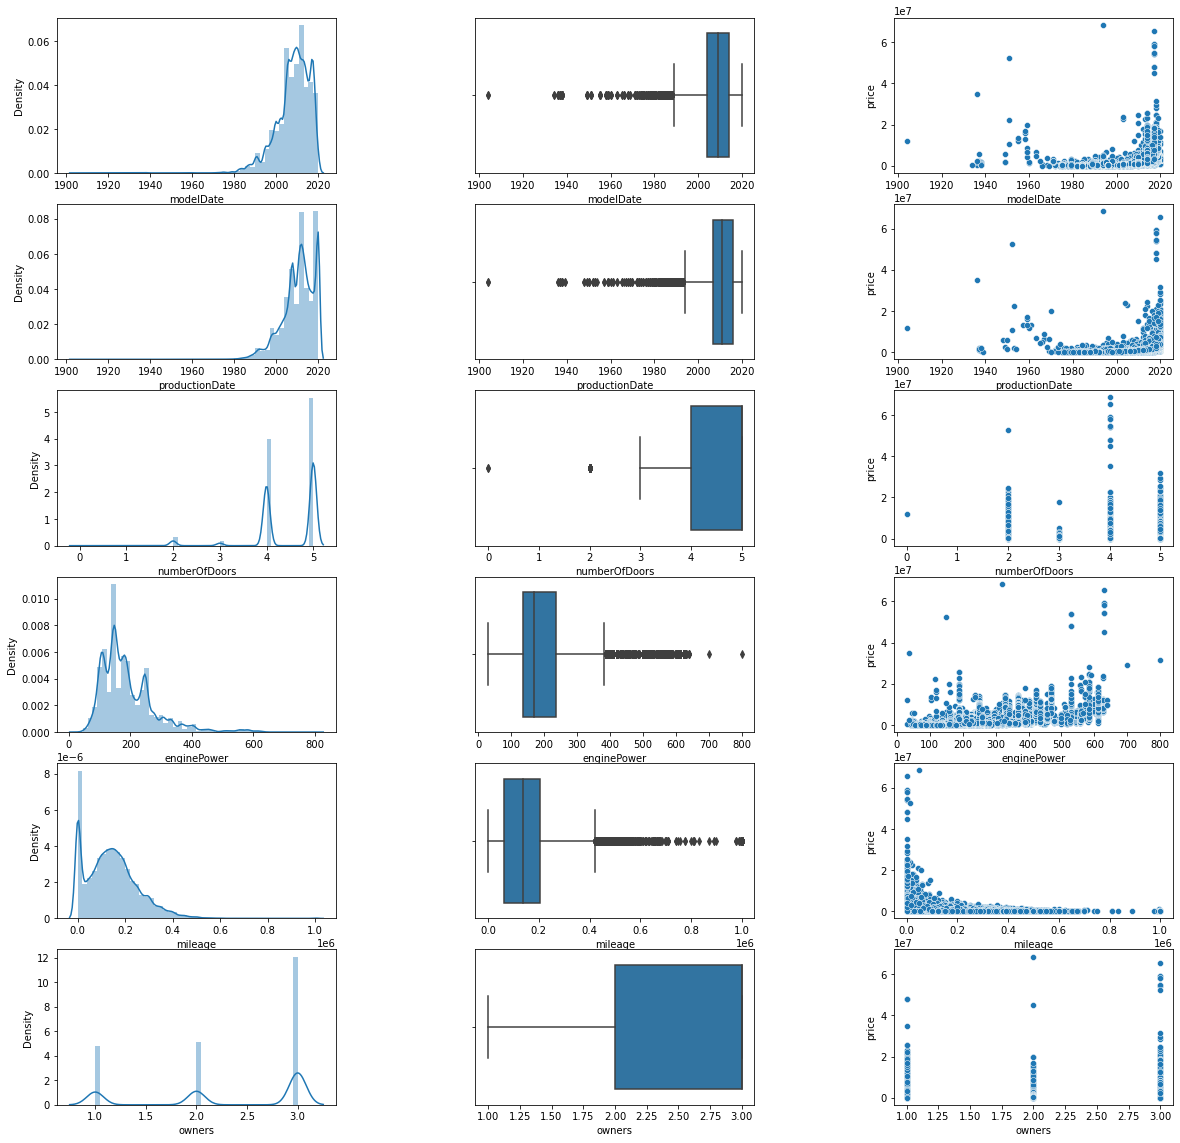

In [99]:
# Построим распределение числовых признаков

print("Диаграмы распределения числовых признаков, взаимосвязь с целевой переменной")

fig, axes = plt.subplots(6, 3, figsize=(20, 20))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in num_cols:
    sns.distplot(df[col], ax=axes[i])
    i = i + 1
    sns.boxplot(df[col], ax=axes[i])
    i = i + 1
    sns.scatterplot(data=df[df['sample'] == 1],
                    x=col, y="price", ax=axes[i])
    i = i + 1

In [100]:
#прологорифмируем явно перекошенные признаки с большим количеством значений.
#fig, axes = plt.subplots(2, 2, figsize=(16, 6))
#for i, col in enumerate(['enginePower', 'mileage']):
#    num_cols.append(f"{col}_log")
#    train[f"{col}_log"] = np.log(train[col] + 1)
#    test[f"{col}_log"] = np.log(test[col] + 1)
#    hist = sns.histplot(train[f"{col}_log"], bins=40, ax=axes.flat[i], kde=False)
#    hist.set(ylabel="")

# не взлетела наработочка сразу, но времени нет.

In [101]:
num_cols

['modelDate',
 'productionDate',
 'numberOfDoors',
 'enginePower',
 'mileage',
 'owners']

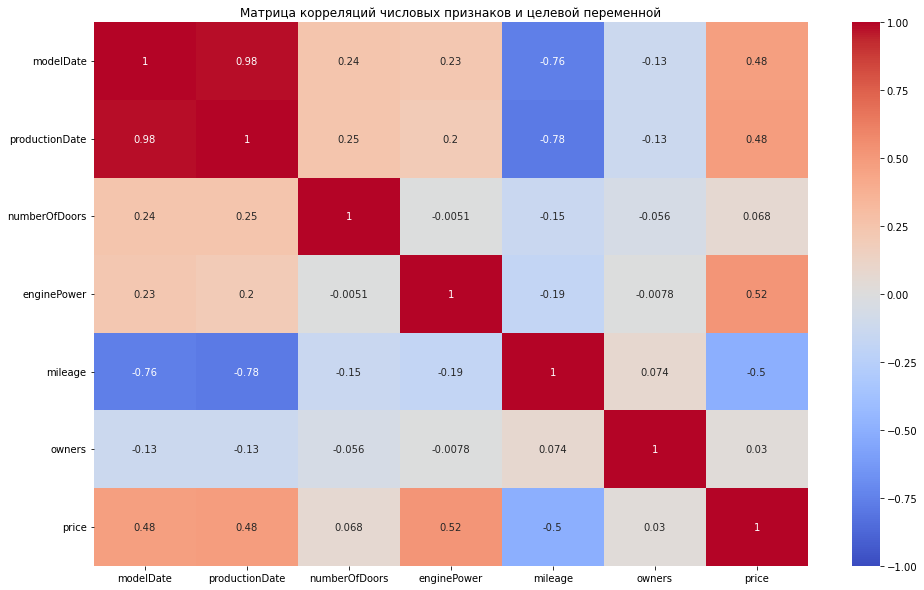

In [102]:
# Построим матрицу корреляций для числовых признаков и целевой переменной
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df[df['sample'] == 1][num_cols+target_col].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Матрица корреляций числовых признаков и целевой переменной')
plt.show()

Оценка важности числовых признаков на целевую переменную


<AxesSubplot:>

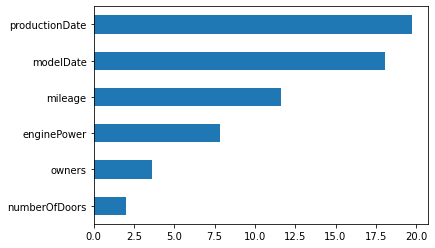

In [103]:
print('Оценка важности числовых признаков на целевую переменную')
imp_num = pd.Series(f_classif(
    df[df['sample'] == 1][num_cols], df[df['sample'] == 1]['price'])[0], index=num_cols)
imp_num.sort_values(inplace=True)
imp_num.plot(kind='barh')

Выводы:

Новых автомобилей больше, чем старых.

Большиинство автомобилей с пробегом больше 100, тыс км, которыми вдадели не менее трех человек.

Между годом выпуска модели и год производства авто почти абсолютная корреляция.

Нулевые значения есть только в пробеге и количестве дверей(это старый автомобиль 1904 года).

Все числовые признаки кооррелируют с целевой переменной, поэтому оставляем все как есть.

Два признака (Количество дверей и Владельцы) лучше перевести в категориальные

In [104]:
#df.drop(['modelDate'], axis=1, inplace=True)
#num_cols.remove('modelDate')

#к великому моему удивлению, этот шаг заметно ухудшает результат.

In [105]:
num_cols.remove('owners')
cat_cols.append('owners')
num_cols.remove('numberOfDoors')
cat_cols.append('numberOfDoors')

### КАТЕГОРИАЛЬНЫЕ И БИНАРНЫЕ ПЕРЕМЕННЫЕ

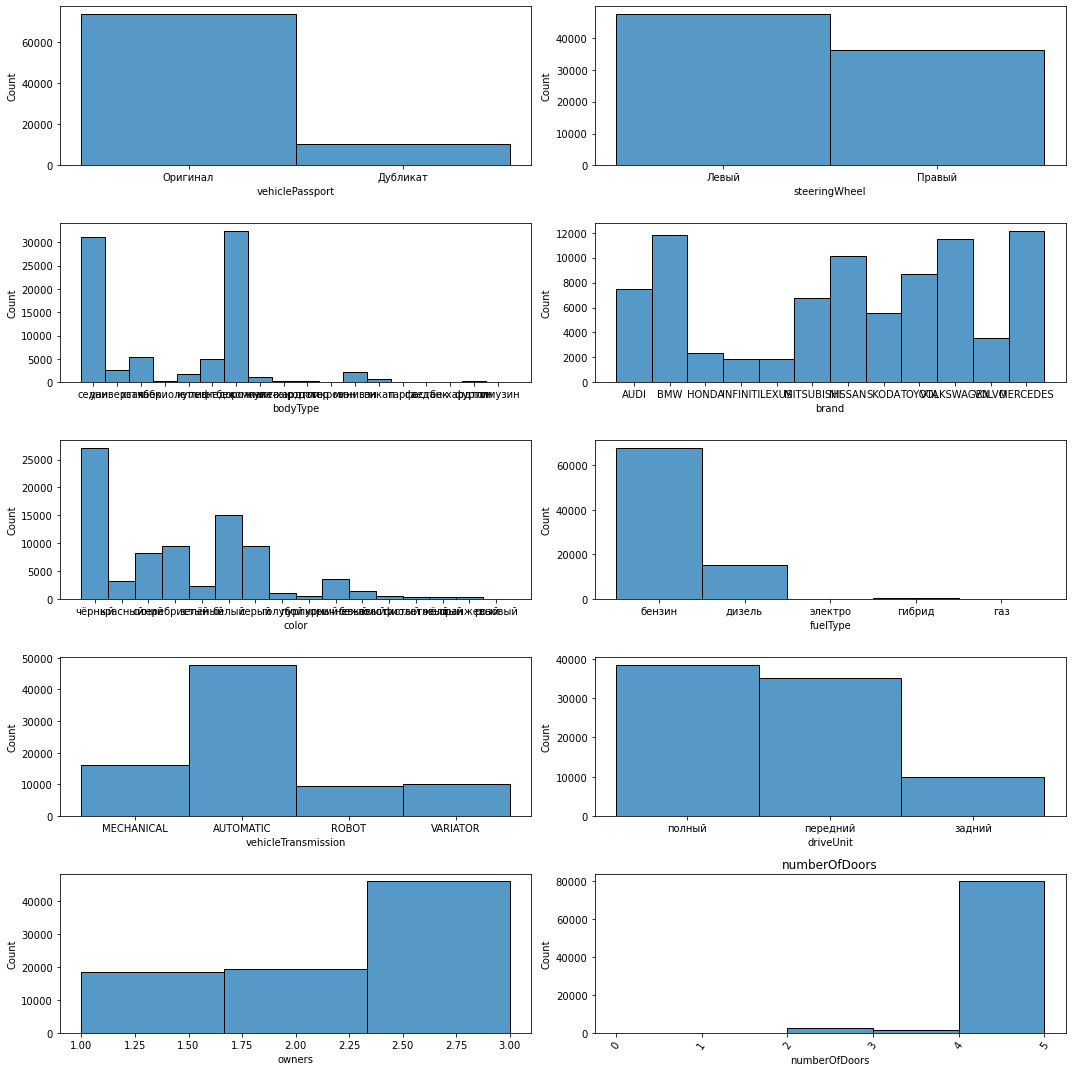

In [106]:
# Построим распределение основных бинарных и категориальных признаков
# не беря в расчет признаки с большим количеством категорий:

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.5)
axes = axes.flatten()
i = 0

for col in (bin_cols + cat_cols):
    sns.histplot(data=df, x=df[col], ax=axes[i],
                 stat='count', bins=df[col].nunique())
    plt.tight_layout()
    plt.xticks(rotation=55)
    plt.title(col)
    i = i + 1

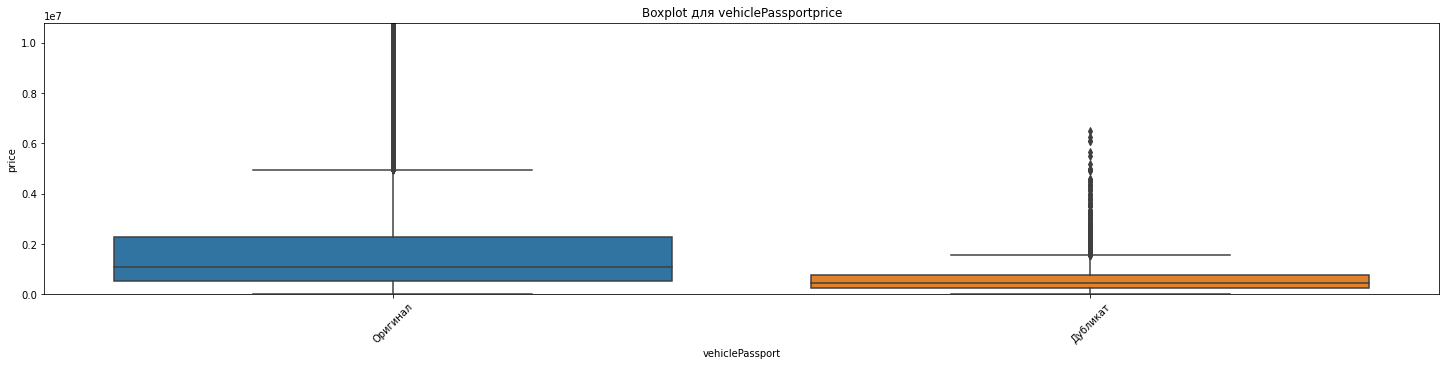

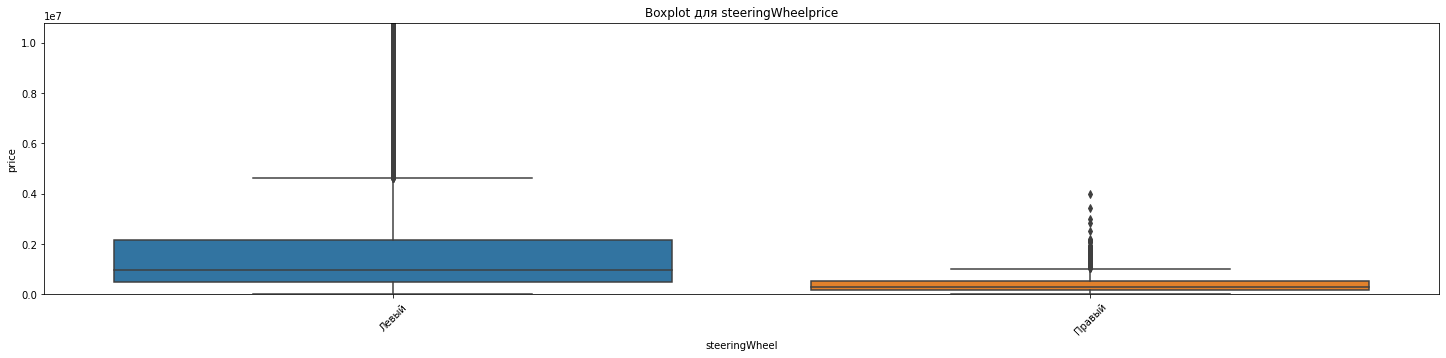

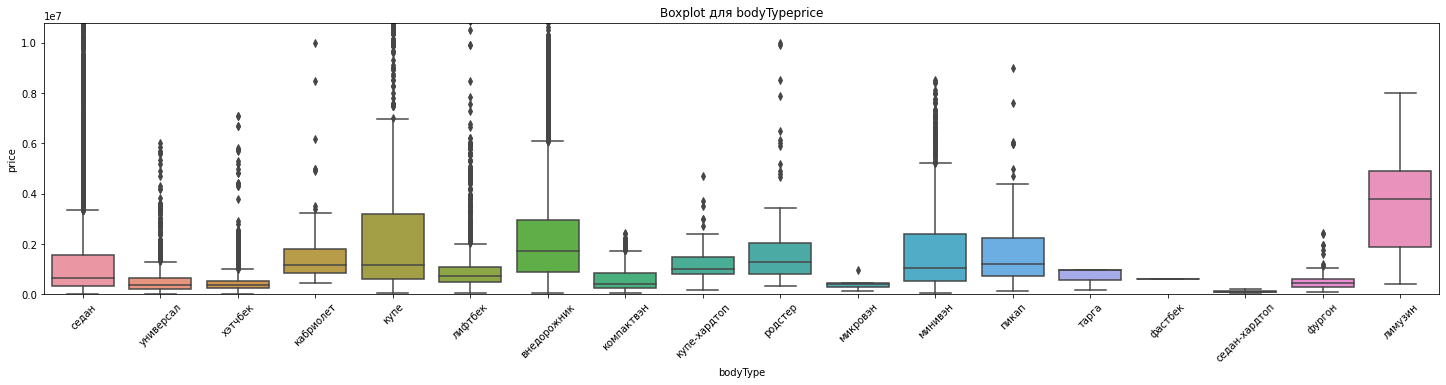

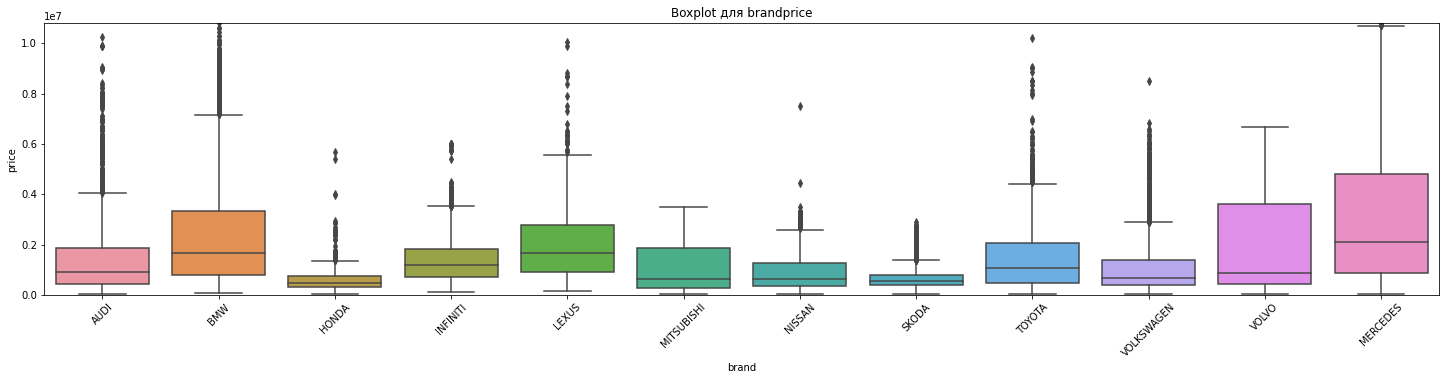

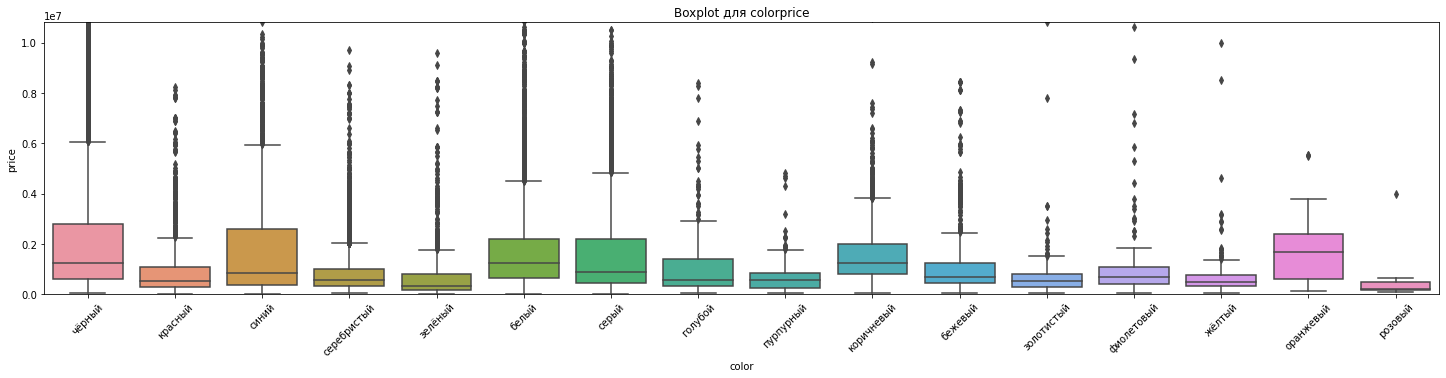

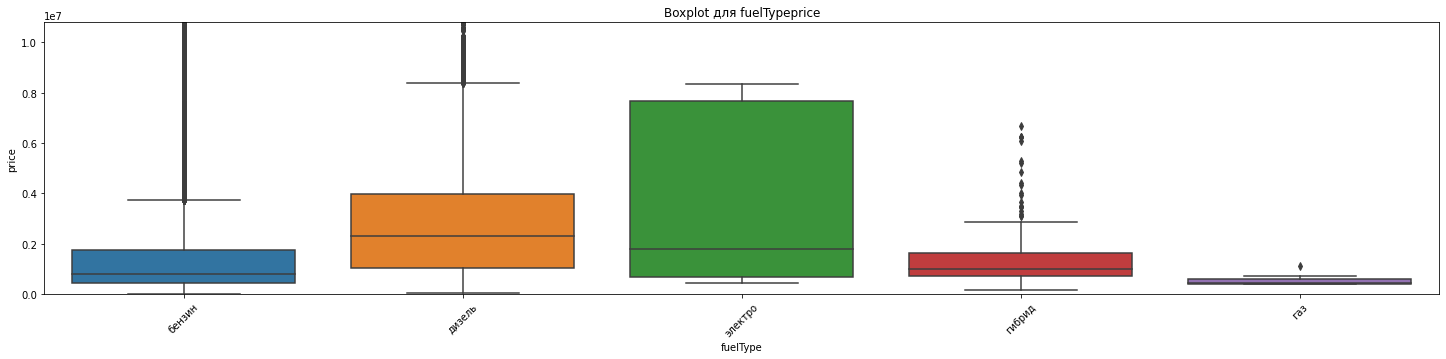

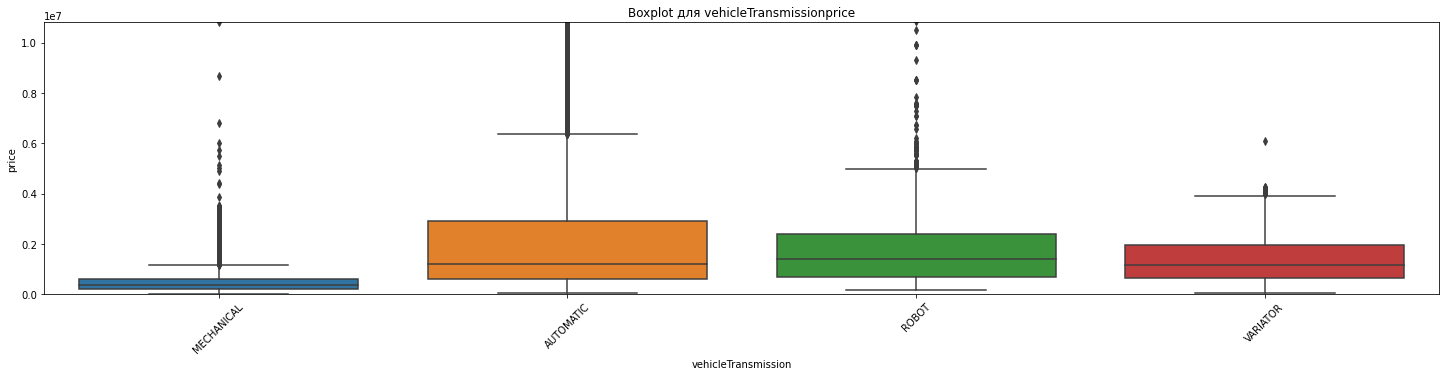

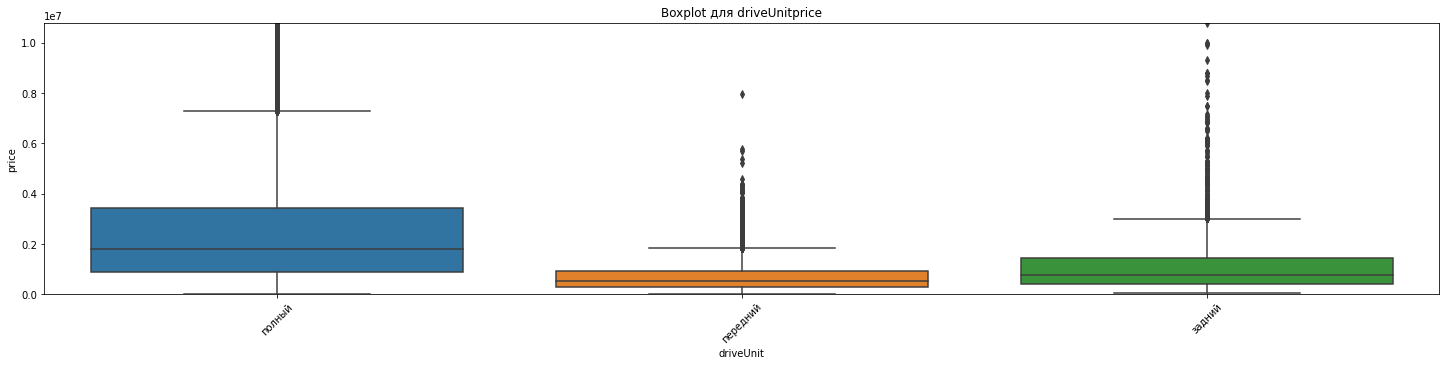

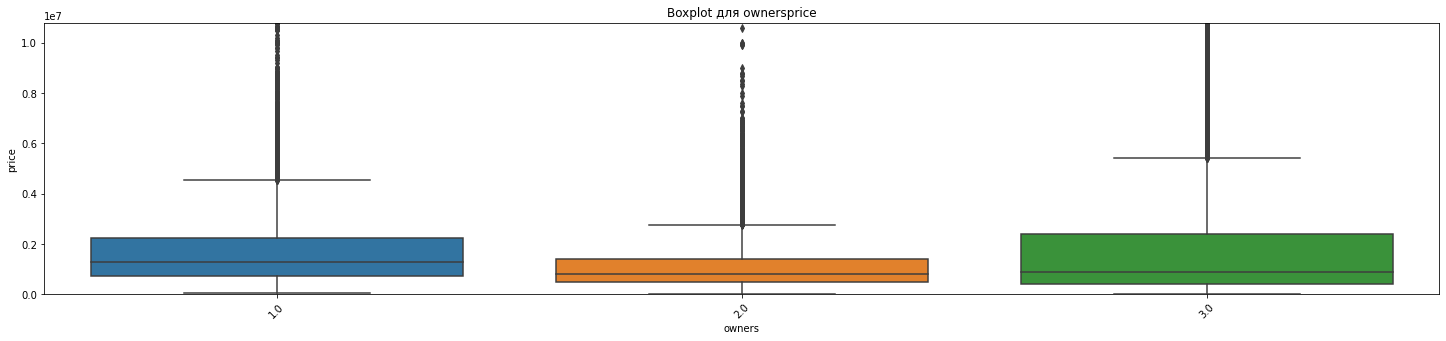

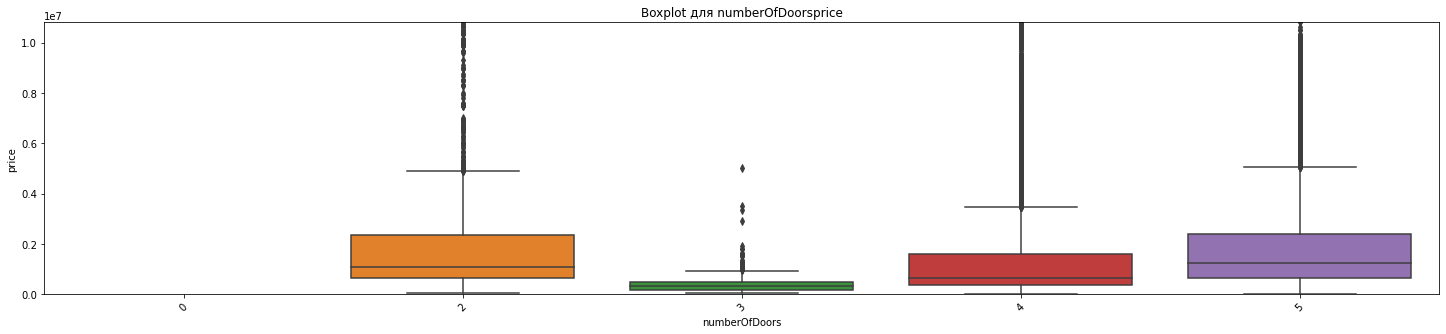

In [107]:
# построим боксплоты для бинарных и категориальных признаков: 
for col in (bin_cols + cat_cols):    
    get_boxplot(col)

##### Выводы:
Относительно сбалансировнные признаки: owners, vohicleTransmission, driveUnit. Превалируют авто с количеством владельцев 3, с автоматической кобобкой передач и с передним либо полным приводом. По отношению к цене: самые дорогие машины с полным приводом, минимальным количеством владельцев, коробкой передач ROBOT.

Плохо сбалансированные признаки:

vehiclePassport - авто в основном с оригиналом ПТС и цена таких машин выше

steeringWheel - леворульных машин больше и они дороже праворульных

brand - 5 марок (MERCEDES ,BMW, VOLKSWAGEN, NISSAN и TOYOTA) составляют почти половину всех авто, из которых к самым догорим относится только MERCEDES.

bodyType - много видов кузова, превалируют "седан" и "внедорожник", по цене самые дорогие авто в кузове "лимузин", но их количество ничтожно.

color - из 16 цветов самый распространенный черный, за ним идут белый, серебристый, серый и синий. К самым дорогим цветам оносятся черний, синий, белый , коричневый и оранженый.

fuelType - тип топлива превалирует -бензин, но самые дорогие авто с электродвигателем, хотя их количество минимально.

numberOfDoors - в основном авто пятидверные, по дороговизне они занимают второе место после двухдверных.

### Анализ целевой переменной (price)

In [108]:
df.price[df['sample'] == 1].describe()

count    4.903200e+04
mean     1.716296e+06
std      2.294285e+06
min      2.000000e+04
25%      4.750000e+05
50%      9.400000e+05
75%      2.090000e+06
max      6.850000e+07
Name: price, dtype: float64

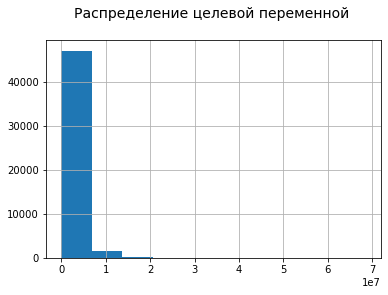

In [109]:
# посмотрим на распределение целевой переменной:
df.query('sample == 1').price.hist();
plt.title("Распределение целевой переменной \n", fontdict={'fontsize': 14});
plt.show()

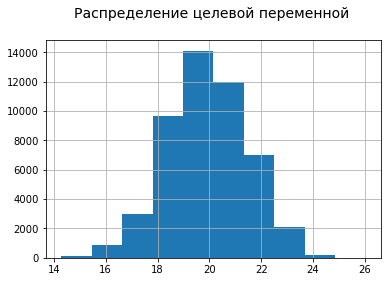

In [110]:
np.log2(df.query('sample == 1').price).hist()
plt.title('Распределение целевой переменной \n', fontdict={'fontsize': 14})

# добавили новый признак в датасет:
df['price_log'] = np.log2(df.price)

После логарифмирвания целевая переменная имеет распределение приближенное к нормальному.

## Работа с выбросами

In [111]:
# Проанализируем выбросы для числовых признаков
print("Отчет о наличии выбросов.\n")
for col in (num_cols + target_col):
    print("\nПризнак: ", col)
    iqr_test(df[col])
    print("-" * 100)

Отчет о наличии выбросов.


Признак:  modelDate

25-й перцентиль: 2004, 
75-й перцентиль: 2014, 
IQR: 10,  
Границы выбросов: [1989.0, 2029.0]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2020 .

Найдены выбросы по нижней границе признака: Количество: 1881, 2.25%
----------------------------------------------------------------------------------------------------

Признак:  productionDate

25-й перцентиль: 2007.0, 
75-й перцентиль: 2016.0, 
IQR: 9.0,  
Границы выбросов: [1993.5, 2029.5]. 

Минимальное значение признака: 1904. 
Максимальное значение признака: 2020 .

Найдены выбросы по нижней границе признака: Количество: 2726, 3.26%
----------------------------------------------------------------------------------------------------

Признак:  enginePower

25-й перцентиль: 135, 
75-й перцентиль: 235, 
IQR: 100,  
Границы выбросов: [-15.0, 385.0]. 

Минимальное значение признака: 30. 
Максимальное значение признака: 800 .

Найдены выбросы по верхней границе при

Выбросов не так много и они похожи на реальные данные. Например, раритетный автомобиль без дверей, который может стоить очень дорого. Самые большие выбросы присутствуют в целевой переменной. Но избавляться от них не будем.

## Feature Engineering

In [112]:
#Создадим числовой столбец возраст ('age'). С учетом того, что все даные взяты в 2020 году от него и будем отталкиваться:
df['age']= 2020-df.productionDate

In [113]:
df.age[(df.age<10)].value_counts()

0    10332
8     5789
9     5509
7     5044
6     4328
5     3507
4     3232
3     3225
2     3039
1     2991
Name: age, dtype: int64

In [114]:
# На его основе сделаем бинарный признак для автомобилей с возрастом 10 лет и старше (0 - моложе 10 лет):
df['age_old'] = df.age.apply(lambda x: 0 if x<10 else 1)

In [115]:
df.age_old.value_counts()

0    46996
1    36722
Name: age_old, dtype: int64

In [116]:
# Создадим аналогичный признак по пробегу больше 120000 км (примерно половина выборки), где 0-авто с меньшим пробегом:
print(df.mileage[(df.mileage > 120000)].value_counts().sum())
df['mileage_120000'] = df.mileage.apply(lambda x: 1 if x > 120000 else 0)

46645


In [117]:
df.mileage_120000.value_counts()

1    46645
0    37073
Name: mileage_120000, dtype: int64

In [118]:
#Создадим бинарный признак для 'свежих' автомобилей: возраст не более 5 лет, пробег менее 60000 и не более двух владельцев, 
#одним из которых зачастую является автосалон.

#df['new'] = df[['age', 'owners', 'mileage']].apply(
#    lambda x: 1 if (x[0] <= 5) and (x[1] <= 2) and (x[2]<=60000) else 0, axis=1)

#pd.DataFrame(df.new.value_counts())

In [119]:
#этот признак очень сильно смещен в сторону "несвежих"

#	new
#0	76182
#1	7536

In [120]:
#добавим бинарный признак для автомобилей без пробега

#df['null'] = df.mileage.apply(lambda x: 1 if x==0 else 0)

In [121]:
# добавим новые признаки в бинарные переменные:
bin_cols.append('age_old')
bin_cols.append('mileage_120000')
#bin_cols.append('new') #не работает
#bin_cols.append('null') #не работает

In [122]:
bin_cols

['vehiclePassport', 'steeringWheel', 'age_old', 'mileage_120000']

In [123]:
# избавимся от буквенных значений в бинарных признакаx:
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])

In [124]:
df[bin_cols].sample(5)

,vehiclePassport,steeringWheel,age_old,mileage_120000
45521,1,0,0,0
12804,1,0,0,0
70657,1,1,0,1
55968,1,1,1,1
1442,1,0,0,0


In [125]:
# применяем Labels encoding к категориальным признакам c большим количеством категорий:
for col in cat_cols_many:
    df[col] = df[col].astype('category').cat.codes 

In [126]:
df[cat_cols_many]

,name,model_name
0,1438,1
1,507,1
2,1098,1
3,507,1
4,839,1
...,...,...
83714,2071,20
83715,2557,25
83716,2569,25
83717,1529,518


In [127]:
# закодируем остальные категоральные переменные:
for col in cat_cols:
    df[col] = df[col].astype('category').cat.codes 

In [128]:
df[cat_cols]

,bodyType,brand,color,fuelType,vehicleTransmission,driveUnit,owners,numberOfDoors
0,11,0,15,0,1,2,2,3
1,11,0,7,0,1,1,2,3
2,14,0,13,0,1,2,2,4
3,11,0,11,0,1,1,2,3
4,11,0,15,0,1,1,2,3
...,...,...,...,...,...,...,...,...
83714,11,1,6,0,0,0,2,3
83715,11,1,15,3,0,2,0,3
83716,11,1,12,0,0,0,2,3
83717,0,1,6,3,0,2,1,4


In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83718 entries, 0 to 83718
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   bodyType             83718 non-null  int8   
 1   brand                83718 non-null  int8   
 2   color                83718 non-null  int8   
 3   fuelType             83718 non-null  int8   
 4   modelDate            83718 non-null  Int64  
 5   name                 83718 non-null  int16  
 6   numberOfDoors        83718 non-null  int8   
 7   productionDate       83718 non-null  int64  
 8   vehicleTransmission  83718 non-null  int8   
 9   enginePower          83718 non-null  Int64  
 10  mileage              83718 non-null  int64  
 11  driveUnit            83718 non-null  int8   
 12  steeringWheel        83718 non-null  int32  
 13  owners               83718 non-null  int8   
 14  vehiclePassport      83718 non-null  int32  
 15  price                83718 non-null 

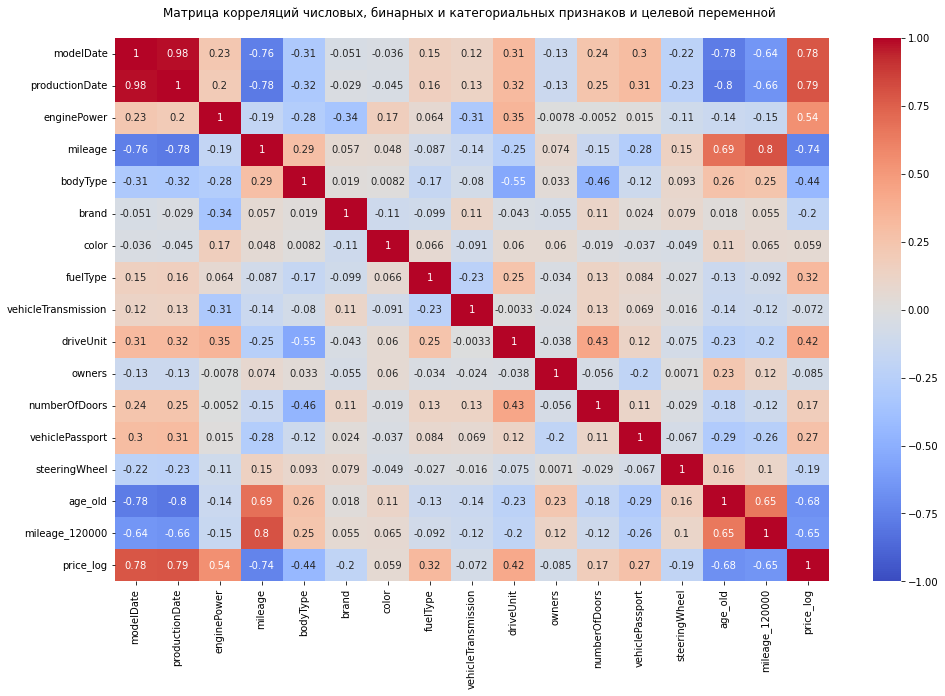

In [130]:
# Построим матрицу корреляций для числовых, бинарных и категориальных признаков и целевой переменной
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(df[df['sample'] == 1][num_cols+cat_cols+bin_cols + ['price_log']].corr(), vmin=-1, vmax=1, annot=True, cmap='coolwarm')
heatmap.set_title('Матрица корреляций числовых, бинарных и категориальных признаков и целевой переменной \n')
plt.show()

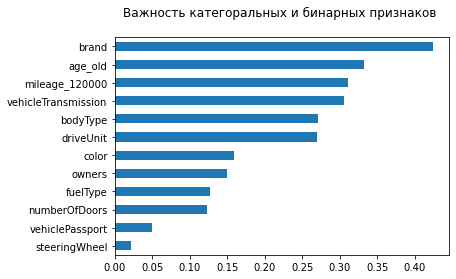

In [131]:
# Теперь посмотрим на важность бинарных и категоральных признаков логарифмированному таргету
imp_cat = pd.Series(
    mutual_info_regression(
        df[df['sample'] == 1][list(set(df.columns) & set(cat_cols+bin_cols))],
        df[df['sample'] == 1]['price_log'],
        discrete_features=True), index=list(set(df.columns) & set(cat_cols+bin_cols))
)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh', title='Важность категоральных и бинарных признаков \n')
plt.show()

## Machine Learning

### Split

In [132]:
# Создадим первое разделение для наивной модели:
X = df.query('sample == 1').drop(['sample', 'sell_id','price', 'price_log'], axis=1)
X_sub = df.query('sample == 0').drop(['sample', 'sell_id','price','price_log'], axis=1)

In [133]:
y = df.query('sample == 1').price

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [135]:
tmp_train = X_train.copy()
tmp_train['price'] = y_train

### Модель 1 - Наивная модель

In [136]:
# Находим median по экземплярам mileage в трейне и размечаем тест
predict = X_test['mileage'].map(
    tmp_train.groupby('mileage')['price'].median())

# оцениваем точность
print(
    f"Точность наивной модели по метрике MAPE: {(mape(y_test, predict.values))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 68.66%


### Модель 2 - CatBoost

Модель CatBoostRegressor хорошо работает с категориальными признаками, числовые признаки надо прологарифмировать для использования.Параметры для этой модели были взяты из Baseline.

In [137]:
# Применим логарифмирование ко всем числовым признакам
for col in num_cols:
    df[col] = df[col].apply(lambda w: np.log(w+1))

In [138]:
df[num_cols] # проверяем логарифмировние числовых признаков

,modelDate,productionDate,enginePower,mileage
0,7.596392,7.596894,5.164786,12.765691
1,7.592366,7.594381,4.510860,12.063501
2,7.595387,7.595890,4.919981,12.345839
3,7.595387,7.595890,4.510860,12.388398
4,7.596392,7.596894,4.624973,12.611541
...,...,...,...,...
83714,7.606885,7.608374,4.919981,11.652696
83715,7.609367,7.610358,5.252273,11.492733
83716,7.598900,7.599902,5.141664,12.793862
83717,7.607381,7.607878,5.220356,11.413116


In [139]:
# готовим выборку для обучения и теста:
X_2_1 = df.query('sample == 1')[cat_cols + bin_cols+num_cols + cat_cols_many]
X_sub_2_1 = df.query('sample == 0')[cat_cols + bin_cols+num_cols + cat_cols_many]

In [140]:
X_train, X_test, y_train, y_test = train_test_split(X_2_1, y, test_size=VAL_SIZE, shuffle=True, random_state=RANDOM_SEED)

In [141]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['R2', 'MAE'],
                          silent=True,
                         )
model.fit(X_train, y_train,
         #cat_features=cat_features_ids,
         eval_set=(X_test, y_test),
         verbose_eval=0,
         use_best_model=True,
         #plot=True
         )

model.save_model('catboost_single_model_baseline.model')

In [142]:
# оцениваем точность
predict = model.predict(X_test)
print(f"Точность модели по метрике MAPE: {(mape(y_test, predict))*100:0.2f}%")

Точность модели по метрике MAPE: 13.79%


Результат заметно улучшился. Попробуем другие модели и посмотрим как работают другие модели по сравнению с CatBoost

Разбиение, используемое на второй модели менять не будем.

### Модель 3 RandomForestRegressor

In [143]:
rf = RandomForestRegressor(random_state = RANDOM_SEED)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

print(
    f"Точность модели по метрике MAPE без логтаргета: {(mape(y_test, rf_pred))*100:0.2f}%")

# с логарифмированием целевой переменной
rf_log = RandomForestRegressor(random_state = RANDOM_SEED)
rf_log.fit(X_train, np.log(y_train))
rf_log_pred = np.exp(rf_log.predict(X_test))

print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, rf_log_pred))*100:0.2f}%")

Точность модели по метрике MAPE без логтаргета: 14.07%
Точность модели по метрике MAPE с логтаргетом: 12.44%


In [144]:
# Подбор гирерпараметров для модели:
#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
#               'max_features': ['sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(1, 10, num=10)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#rfr = RandomForestRegressor(random_state=RANDOM_SEED)
#rf_random = RandomizedSearchCV(estimator=rfr, param_distributions=random_grid,
#                               n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)

#rf_random.fit(X_train, np.log(y_train))
#rf_random.best_params_

In [145]:
#Выдача предыдущей ячейки
#{'n_estimators': 800,
# 'min_samples_split': 10,
# 'min_samples_leaf': 1,
# 'max_features': 'sqrt',
# 'max_depth': None,
# 'bootstrap': False}

In [146]:
# Обучим модель на лучших гиперпараметрах

#best_rfr = rf_random.best_estimator_
best_rfr = RandomForestRegressor(random_state=RANDOM_SEED
                      , n_estimators=800
                      , min_samples_split=10
                      , min_samples_leaf=1
                      , max_features='sqrt'
                      , max_depth=None
                      , bootstrap=False)

# best_rfr.fit(X_train, y_train)
best_rfr.fit(X_train, np.log(y_train))

# predict_rfr = best_rfr.predict(X_test)
predict_rfr = np.exp(best_rfr.predict(X_test))
print(
    f"Точность оптимизированной модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_rfr))*100:0.2f}%")

Точность оптимизированной модели по метрике MAPE с логтаргетом: 11.92%


Логарифмирование таргета сильно улучшает показатель MAPE, поэтому в дальнейшем будем использовать только логтаргет.

### Модель 4 - LGBMRegressor

In [147]:
# Запустим модель со стандартными параметрами
lgbm = LGBMRegressor(random_state=RANDOM_SEED)
lgbm.fit(X_train, np.log(y_train))
predict_lgbm = np.exp(lgbm.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_lgbm))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 13.73%


In [148]:
#подберем оптимальные параметры
#params = {'num_leaves': [14, 21, 28, 31, 50, 65],
#          'learning_rate': [0.1, 0.03, 0.003],
#          'max_depth': [-1, 3, 5],
#          'n_estimators': [50, 100, 200, 500]
#         }

#grid = GridSearchCV(LGBMRegressor(random_state=0), params, scoring='r2', cv=5)
#grid.fit(X_train, np.log(y_train))

#grid.best_params_

In [149]:
#Выдача предыдущей ячейки
#{'learning_rate': 0.1, 'max_depth': -1, 'n_estimators': 500, 'num_leaves': 50}

In [150]:
lgbm_tuned = LGBMRegressor(num_leaves=50, max_depth=-1, learning_rate=0.1, n_estimators=500, random_state=RANDOM_SEED)
    
lgbm_tuned.fit(X_train, np.log(y_train))
predict_lgbm_tuned = np.exp(lgbm_tuned.predict(X_test))
print(
    f"Точность оптимизированной модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_lgbm_tuned))*100:0.2f}%")

Точность оптимизированной модели по метрике MAPE с логтаргетом: 12.15%


### Модель 5 - XGBRegressor

In [151]:
# Запустим модель со стандартными параметрами
xgb = xgb.XGBRegressor(random_state=RANDOM_SEED, n_jobs=-1)

xgb.fit(X_train, np.log(y_train))
predict_xgb = np.exp(xgb.predict(X_test))
print(
    f"Точность модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_xgb))*100:0.2f}%")

Точность модели по метрике MAPE с логтаргетом: 12.72%


In [152]:
#import xgboost as xgb
#from xgboost.sklearn import XGBRegressor

#import datetime

#st = datetime.datetime.now()

#xgb = xgb.XGBRegressor()
#parameters = {'objective':['reg:logistic', 'reg:squarederror'],
#              'learning_rate': [.03, .04],
#              'max_depth': [5, 10],
#              'colsample_bytree': [0.5, 0.7],
#              'n_estimators': [500, 1000],
#              }

#xgb_grid = GridSearchCV(xgb,
#                        parameters,
#                        cv = 2,
#                        n_jobs = -1,
#                        verbose=True)

#xgb_grid.fit(X_train, y_train)

#print(xgb_grid.best_score_)
#print(xgb_grid.best_params_)

#fin = datetime.datetime.now()

#print(fin - st)

In [153]:
#выдача предыдущей ячейки
#Fitting 2 folds for each of 32 candidates, totalling 64 fits
#0.9538543221232232
#{'colsample_bytree': 0.5, 'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 1000, 'objective': 'reg:squarederror'}
#0:02:19.658649

In [154]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor #к этому моменту юпитер почему-то забывает о факте импорта

# Запустим модель с оптимизированными параметрами:
xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    colsample_bytree=0.5,
    learning_rate=0.03,
    max_depth=10,
    alpha=1,
    n_estimators=1000,
    random_state=RANDOM_SEED,
    n_jobs=-1)

xgb_tuned.fit(X_train, np.log(y_train))
predict_xgb_tuned = np.exp(xgb_tuned.predict(X_test))
print(
    f"Точность оптимизированной модели по метрике MAPE с логтаргетом: {(mape(y_test, predict_xgb_tuned))*100:0.2f}%")

Точность оптимизированной модели по метрике MAPE с логтаргетом: 11.74%


оптимизация приятно улучшает результат

### Модель 6 -Extra Tree Regressor с подбором гиперпараметров

In [155]:
# Запустим модель со стандартными параметрами
etr = ExtraTreesRegressor(random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
etr.fit(X_train, np.log(y_train))
predict_etr = np.exp(etr.predict(X_test))
print(
    f"Точность модели по метрике MAPE c логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.2s


Точность модели по метрике MAPE c логтаргетом: 12.89%


[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.9s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [156]:
# Попробуем подобрать гиперпараметры для нашей модели

#random_grid = {'n_estimators': [int(x) for x in np.linspace(start=100, stop=1000, num=10)],
#               'max_features': ['auto', 'sqrt', 'log2'],
#               'max_depth': [int(x) for x in np.linspace(5, 15, num=6)] + [None],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False]}

#etr = ExtraTreesRegressor(random_state=RANDOM_SEED)
#etr_random = RandomizedSearchCV(estimator=etr, param_distributions=random_grid,
#                                n_iter=100, cv=3, verbose=1, random_state=RANDOM_SEED, n_jobs=-1)
#rf_random.fit(X_train, y_train)
#etr_random.fit(X_train, np.log(y_train))
#etr_random.best_params_

In [157]:
#выдача предыдущей ячейки
#{'n_estimators': 400,
# 'min_samples_split': 2,
# 'min_samples_leaf': 1,
# 'max_features': 'auto',
# 'max_depth': None,
# 'bootstrap': True}

In [158]:
# Запустим модель с подобранными параметрами:
best_etr = ExtraTreesRegressor(n_estimators = 400,
                               min_samples_split= 2,
                               min_samples_leaf= 1,
                               max_features= 'auto',
                               max_depth= None,
                               bootstrap= True,
                               random_state=RANDOM_SEED, n_jobs=-1, verbose=1)
best_etr.fit(X_train, np.log(y_train))
predict_etr = np.exp(best_etr.predict(X_test))
print(
    f"Точность оптимизированной модели по метрике MAPE c логтаргетом: {(mape(y_test, predict_etr))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    1.1s


Точность оптимизированной модели по метрике MAPE c логтаргетом: 12.28%


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.5s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


## СТЕКИНГ

### 1. Стекинг: LGBMRegressor, Xgboosting +LinearRegression

In [159]:
estimators = [('lgbm', LGBMRegressor(random_state=RANDOM_SEED,
                                     objective='regression',
                                     num_iterations=1000,
                                     n_estimators=500,
                                     learning_rate=0.1,
                                     num_leaves=50,
                                     min_child_samples=3,
                                     colsample_bytree=0.5,
                                     max_depth=-1)),
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror',
                                           colsample_bytree=0.5,
                                           learning_rate=0.03,
                                           max_depth=10,
                                           alpha=1,
                                           n_estimators=1000,
                                           random_state=RANDOM_SEED,
                                           n_jobs=-1))]

st_ensemble_1 = StackingRegressor(
    estimators=estimators, final_estimator=LinearRegression())

# оцениваем точность
st_ensemble_1.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble_1.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Точность модели по метрике MAPE: 11.69%


### 2. Стекинг: Xgboosting, ExtraTreesRegressor+LinearRegression

In [160]:
estimators = [('etr',ExtraTreesRegressor(n_estimators = 400,
                                         min_samples_split= 2,
                                         min_samples_leaf= 1,
                                         max_features= 'auto',
                                         max_depth= None,
                                         bootstrap= True,
                                         random_state=RANDOM_SEED,
                                         n_jobs=-1,
                                         verbose=1)),
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror',
                                           colsample_bytree=0.5,
                                           learning_rate=0.03,
                                           max_depth=10,
                                           alpha=1,
                                           n_estimators=1000,
                                           random_state=RANDOM_SEED,
                                           n_jobs=-1))]

st_ensemble_2 = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

#оцениваем точность¶
st_ensemble_2.fit(X_train, np.log(y_train))
predict_e = np.exp(st_ensemble_2.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    3.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:    2.3s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done 400 out of 4

Точность модели по метрике MAPE: 11.67%


[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 400 out of 400 | elapsed:    0.0s finished


### 3. Стекинг: Xgboosting, RandomForestRegressor+LinearRegression

In [161]:
estimators = [('rfr',RandomForestRegressor(random_state=RANDOM_SEED,
                                           n_estimators=800,
                                           min_samples_split=10,
                                           min_samples_leaf=1,
                                           max_features='sqrt',
                                           max_depth=None,
                                           bootstrap=False)),
              ('xgb_reg', xgb.XGBRegressor(objective='reg:squarederror',
                                           colsample_bytree=0.5,
                                           learning_rate=0.03,
                                           max_depth=10,
                                           alpha=1,
                                           n_estimators=1000,
                                           random_state=RANDOM_SEED,
                                           n_jobs=-1))]

st_ensemble_3 = StackingRegressor(estimators=estimators,final_estimator=LinearRegression())

#оцениваем точность
st_ensemble_3.fit(X_train, np.log(y_train))

predict_e = np.exp(st_ensemble_3.predict(X_test))
print(
    f"Точность модели по метрике MAPE: {(mape(y_test, predict_e))*100:0.2f}%")

Точность модели по метрике MAPE: 11.62%


## Submission

In [162]:
predict_sub = np.exp(st_ensemble_1.predict(X_sub_2_1))
sample_submission['price'] = predict_sub
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,6.263817e+05
1,1100549428,8.898969e+05
2,1100658222,8.644516e+05
3,1100937408,6.963827e+05
4,1101037972,7.085317e+05
5,1100912634,7.651765e+05
6,1101228730,5.809489e+05
7,1100165896,4.079496e+05
8,1100768262,1.771706e+06
9,1101218501,7.770716e+05


In [163]:
import datetime

end = datetime.datetime.now()

print(end - start)

0:07:25.309545


на Kaggle результат работы третьего ансамбля получил оценку в 12.08224%, второго - в 12.06076%, а первого - 12.04052%.
На этом пока и остановимся.